In [4]:
import os
import shutil
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split

In [6]:
# Define the paths
source_path = 'PetImages'
base_dir = 'images'

# Create directories
os.makedirs(base_dir, exist_ok=True)
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Function to split data into train, validation, test
def split_data(source, train_dir, val_dir, test_dir, test_size=0.2):
    # Get all filenames for cats and dogs
    cat_files = [os.path.join(source, 'Cat', file) for file in os.listdir(os.path.join(source, 'Cat')) if os.path.isfile(os.path.join(source, 'Cat', file))]
    dog_files = [os.path.join(source, 'Dog', file) for file in os.listdir(os.path.join(source, 'Dog')) if os.path.isfile(os.path.join(source, 'Dog', file))]
    
    # Split cat data into train and temporary data
    cat_train, cat_temp = train_test_split(cat_files, test_size=test_size, random_state=42)
    # Split dog data into train and temporary data
    dog_train, dog_temp = train_test_split(dog_files, test_size=test_size, random_state=42)
    
    # Split temporary cat data into validation and test data
    cat_val, cat_test = train_test_split(cat_temp, test_size=0.5, random_state=42)
    # Split temporary dog data into validation and test data
    dog_val, dog_test = train_test_split(dog_temp, test_size=0.5, random_state=42)
    
    # Function to copy files
    def copy_files(files, directory):
        os.makedirs(directory, exist_ok=True)
        for file in files:
            shutil.copy(file, directory)
    
    # Copy cat files
    copy_files(cat_train, os.path.join(train_dir, 'Cat'))
    copy_files(cat_val, os.path.join(val_dir, 'Cat'))
    copy_files(cat_test, os.path.join(test_dir, 'Cat'))
    
    # Copy dog files
    copy_files(dog_train, os.path.join(train_dir, 'Dog'))
    copy_files(dog_val, os.path.join(val_dir, 'Dog'))
    copy_files(dog_test, os.path.join(test_dir, 'Dog'))

# Call the function
split_data(source_path, train_dir, val_dir, test_dir)

# Note: Update the path settings in your main code to match 'train_dir', 'val_dir', 'test_dir'
train_path = train_dir  
val_path = val_dir
test_path = test_dir

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input

# Define data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_val_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_val_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 19998 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 2502 images belonging to 2 classes.


In [9]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load DenseNet121 model
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Add custom layers for transfer learning
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)  # Change the number of units to match your number of classes (2 for cat and dog)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

In [10]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
history = model.fit(
    train_generator,
    steps_per_epoch=20,  # Adjust based on the size of your dataset
    epochs=7,  # Adjust based on your early experiments
    validation_data=validation_generator,
    validation_steps=15  # Adjust based on the size of your validation set
)

Epoch 1/7
20/20 [==============================] - 146s 7s/step - loss: 0.1913 - accuracy: 0.9156 - val_loss: 0.7211 - val_accuracy: 0.8021
Epoch 2/7
20/20 [==============================] - 146s 7s/step - loss: 0.1760 - accuracy: 0.9297 - val_loss: 0.3484 - val_accuracy: 0.8854
Epoch 3/7
20/20 [==============================] - 146s 7s/step - loss: 0.2123 - accuracy: 0.9078 - val_loss: 0.3582 - val_accuracy: 0.8917
Epoch 4/7
20/20 [==============================] - 147s 7s/step - loss: 0.1905 - accuracy: 0.9266 - val_loss: 0.3233 - val_accuracy: 0.9104
Epoch 5/7
20/20 [==============================] - 146s 7s/step - loss: 0.1845 - accuracy: 0.9312 - val_loss: 0.6811 - val_accuracy: 0.8062
Epoch 6/7
20/20 [==============================] - 147s 7s/step - loss: 0.1761 - accuracy: 0.9328 - val_loss: 0.3242 - val_accuracy: 0.8896
Epoch 7/7
20/20 [==============================] - 146s 7s/step - loss: 0.2128 - accuracy: 0.9125 - val_loss: 0.3046 - val_accuracy: 0.8833


In [15]:
test_loss, test_acc = model.evaluate(test_generator, steps=50)  # Adjust the steps as needed
print('Test accuracy:', test_acc)

50/50 [==============================] - 59s 1s/step - loss: 0.3090 - accuracy: 0.8900
Test accuracy: 0.8899999856948853


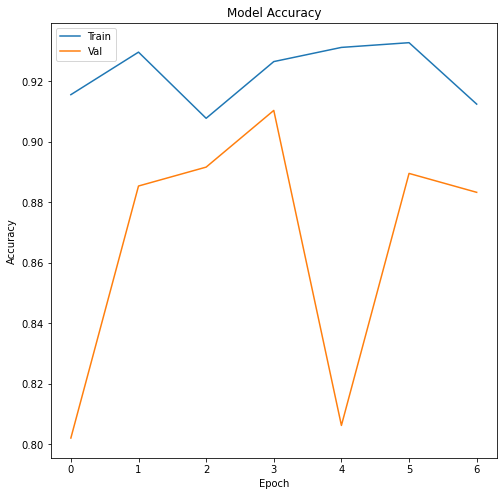

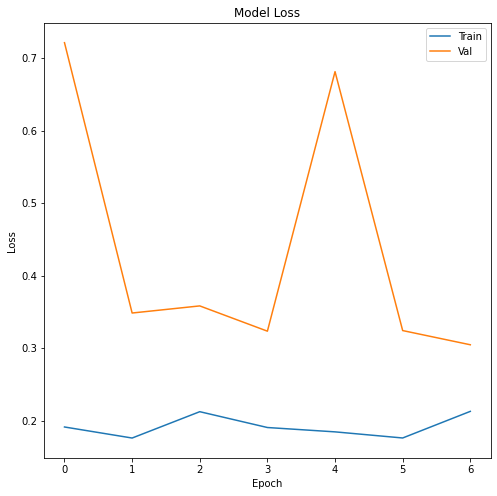

In [16]:
import matplotlib.pyplot as plt

# Summarize history for accuracy
plt.figure(figsize=(8, 8))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Summarize history for loss
plt.figure(figsize=(8, 8))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()